In [1]:
from matplotlib import pyplot as plt
import numpy as np

In [2]:
import sys 
sys.path.insert(0,'..')
import neurosat_policy
neurosat_policy.VARIABLE_NUM = 50

In [3]:
from cnf_dataset import clauses_to_matrix
from dpll_new import DPLL, RandomClauseDPLL, MostCommonVarDPLL, RandomVarDPLL
from cnf_new import get_random_kcnf, CNF, get_sats_SR, get_pos_SR
from tqdm import tqdm
from collections import Counter

In [4]:
np.set_printoptions(precision=2, suppress=True)

In [5]:
import tensorflow as tf
import os

BATCH_SIZE = 1

# META_FILE = "series/18-03-24-020248/var5/models/activepolicy-18-03-24-020450/model-32000000.meta"  # perfect results
# META_FILE = "models/activepolicy-18-03-28-122105/model-10000064.meta" # ok results, no error > 80% usually, usually better than mostcommon
# META_FILE = "series/18-03-24-020248/var8/models/activepolicy-18-03-24-020450/model-6400000.meta"  # usually slightly worse than mostcommon
# META_FILE = "models/neuropol-18-09-18-002956/model-7268352.meta"
META_FILE = "/home/henryk/sat_solving/models/neuropol-restorer-18-10-09-215204-var-50-lev-30/model.ckpt-1945.meta"
# META_DIR = "/home/henryk/sat_solving/models/neuropol-restorer-18-10-09-215204-var-30-lev-30/"

# saver_hook = tf.train.CheckpointSaverHook(checkpoint_dir=META_DIR, save_steps=20)
# summary_hook = tf.train.SummarySaverHook(META_DIR)
# sess = tf.train.MonitoredSession()


sess=tf.Session()    
#First let's load meta graph and restore weights
saver = tf.train.import_meta_graph(META_FILE, clear_devices=True)
sess.run(tf.global_variables_initializer())
saver.restore(sess, tf.train.latest_checkpoint(os.path.dirname(META_FILE)))

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data

graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from /home/henryk/sat_solving/models/neuropol-restorer-18-10-09-215204-var-50-lev-30/model.ckpt-1945


In [6]:
g_inputs = graph.get_tensor_by_name("inputs:0")

In [7]:
#g_policy_probs = graph.get_tensor_by_name('policy_prob:0')
#g_sat_probs = graph.get_tensor_by_name('sat_prob:0')

In [8]:
LEVEL = 30

In [9]:
g_policy_probs = graph.get_tensor_by_name('policy_prob_{}:0'.format(LEVEL))
g_sat_probs = graph.get_tensor_by_name('sat_prob_{}:0'.format(LEVEL))

In [10]:
np.set_printoptions(precision=3, suppress=True)

In [11]:
'''
inputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)
lengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)

sat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})

print(sat_prob[0], policy_probs[0])
'''

'\ninputs = np.asarray([[[1, 1, 3], [1, -3, 2], [1, 3, 4], [-2, -3, 4]]] * BATCH_SIZE, dtype=np.int32)\nlengths = np.asarray([inputs.shape[1]] * 64, dtype=np.int32)\n\nsat_prob, policy_probs = sess.run([g_sat_probs, g_policy_probs], feed_dict={g_inputs: inputs, g_lengths: lengths})\n\nprint(sat_prob[0], policy_probs[0])\n'

In [12]:
# Because we have to pass full batch

logfile = open("/tmp/log_2", "w")
#import sys
#logfile = sys.stdout

class GraphBasedDPLL(DPLL):
    def suggest(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar

In [13]:
class HybridDPLL(DPLL):
    def run(self, cnf: CNF):
        assert isinstance(cnf, CNF)
        self.number_of_runs += 1
        
        if cnf.is_true():
            return []
        elif cnf.is_false():
            return None

        if self.number_of_runs < 200:
            sug_var = self.suggest_neural(cnf)
        else:
            sug_var = self.suggest_most_common(cnf)
            
        sug_cnf = cnf.set_var(sug_var)
        sug_res = self.run(sug_cnf)
        if sug_res is not None:
            return [sug_var] + sug_res

        not_sug_cnf = cnf.set_var(-sug_var)
        not_sug_res = self.run(not_sug_cnf)
        if not_sug_res is not None:
            self.number_of_errors += 1
            return [-sug_var] + not_sug_res
        return None
    
    def suggest_neural(self, input_cnf: CNF):
        clause_num = len(input_cnf.clauses)
        var_num = max(input_cnf.vars)
        inputs = np.asarray([clauses_to_matrix(input_cnf.clauses, clause_num, var_num)] * BATCH_SIZE)
        
        policy_probs = sess.run(g_policy_probs, feed_dict={g_inputs: inputs})
        
        print("CNF:", input_cnf, end=' ', file=logfile)
        print('cnf_clauses[0]', input_cnf.clauses, end=' ', file=logfile)
        print("probs:\n",  policy_probs[0], end='\n', file=logfile)
        
        best_prob = 0.0
        best_svar = None
        for var in input_cnf.vars:
            for svar in [var, -var]:
                svar_prob = policy_probs[0][var-1][0 if svar > 0 else 1]
                print(svar, svar_prob, best_prob, file=logfile)
                if svar_prob > best_prob:
                    best_prob = svar_prob
                    best_svar = svar
        print("best_svar:", best_svar, file=logfile)
        return best_svar
    
    def suggest_most_common(self, cnf: CNF):
        counter = Counter()
        for clause in cnf.clauses:
            for svar in clause:
                counter[svar] += 1
        return counter.most_common(1)[0][0]

In [14]:
def compute_steps(sats, dpll_cls):
    steps = []
    errors = []
    for sat in tqdm(sats):
        dpll = dpll_cls()
        res = dpll.run(sat)
        assert res is not None
        steps.append(dpll.number_of_runs)
        errors.append(dpll.number_of_errors)
    return steps, errors

In [15]:
def compute_and_print_steps(sats, dpll_cls):
    steps, errors = compute_steps(sats, dpll_cls)
    print("#Sats: {}; avg step: {:.2f}; stdev step: {:.2f}; avg error: {:.2f}; stdev error: {:.2f}".format(
        len(steps), np.mean(steps), np.std(steps), np.mean(errors), np.std(errors)))
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 2, 1)
    plt.title("Steps of {}".format(dpll_cls.__name__))
    plt.hist(steps, bins=20) # range(2**(N+1)))
    plt.ylim((0, len(sats)))
    
    plt.subplot(1, 2, 2)
    plt.title("Errors of {}".format(dpll_cls.__name__))
    plt.hist(errors, bins=range(N+1))
    plt.ylim((0, len(sats)))
    plt.show()

In [16]:
def print_all(s, n, m):
    # def get_sats_SR(sample_number, min_variable_number, clause_number, max_variable_number=None):
    global S, N, M
    S = s
    N = n # number of clauses
    M = m # number of variables
    
    MAX_TRIES = 100000
    sats = []
    for index in range(MAX_TRIES):
        if len(sats) >= S:
            break
        sat = get_pos_SR(M, M, N)
        if DPLL().run(sat) is not None:
            sats.append(sat)
    assert len(sats) == S
    # sats = get_sats_SR(S,M,N)
    # for sat in sats:
    #    print(sat)
    # assert len(sats) == S
    print("We have generated {} formulas".format(len(sats)))
    # compute_and_print_steps(sats, DPLL)
    compute_and_print_steps(sats, RandomVarDPLL)
    compute_and_print_steps(sats, RandomClauseDPLL)
    compute_and_print_steps(sats, HybridDPLL)
    compute_and_print_steps(sats, GraphBasedDPLL)
    compute_and_print_steps(sats, MostCommonVarDPLL)
    logfile.flush(), 

 50%|█████     | 5/10 [00:00<00:00, 26.44it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:00<00:00, 35.03it/s]


#Sats: 10; avg step: 683.60; stdev step: 606.90; avg error: 6.80; stdev error: 1.08


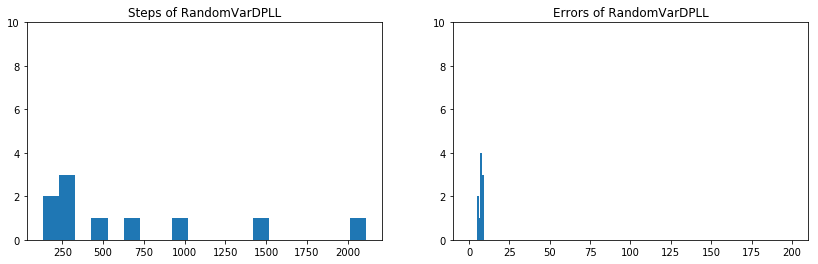

100%|██████████| 10/10 [00:00<00:00, 43.66it/s]


#Sats: 10; avg step: 506.30; stdev step: 332.25; avg error: 4.20; stdev error: 1.54


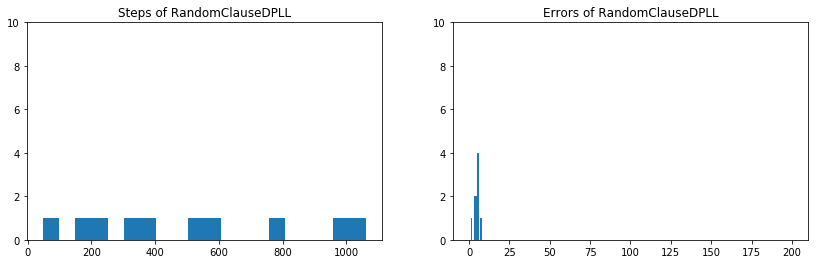

100%|██████████| 10/10 [00:12<00:00,  1.05it/s]


#Sats: 10; avg step: 245.10; stdev step: 295.89; avg error: 1.50; stdev error: 1.69


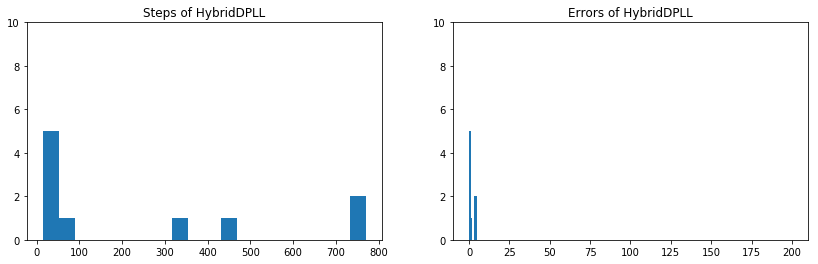

100%|██████████| 10/10 [00:40<00:00,  3.17s/it]


#Sats: 10; avg step: 392.30; stdev step: 524.80; avg error: 0.50; stdev error: 0.50


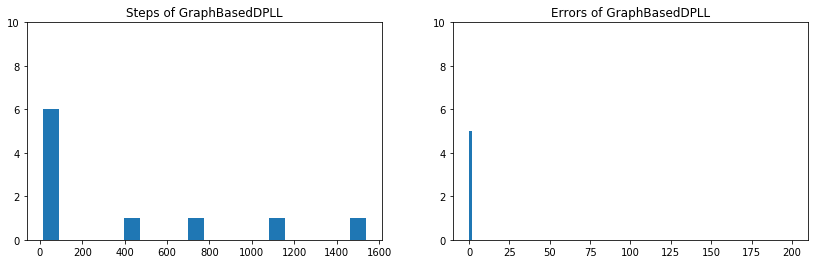

100%|██████████| 10/10 [00:00<00:00, 74.46it/s]


#Sats: 10; avg step: 207.00; stdev step: 185.99; avg error: 2.40; stdev error: 1.28


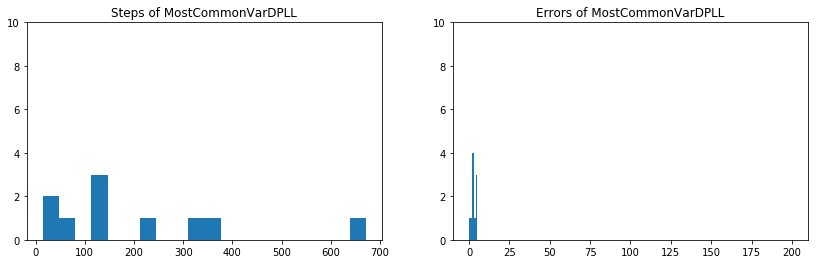

In [17]:
print_all(10, 200, 15)

100%|██████████| 10/10 [00:00<00:00, 511.70it/s]

We have generated 10 formulas
#Sats: 10; avg step: 56.80; stdev step: 32.53; avg error: 3.30; stdev error: 0.90


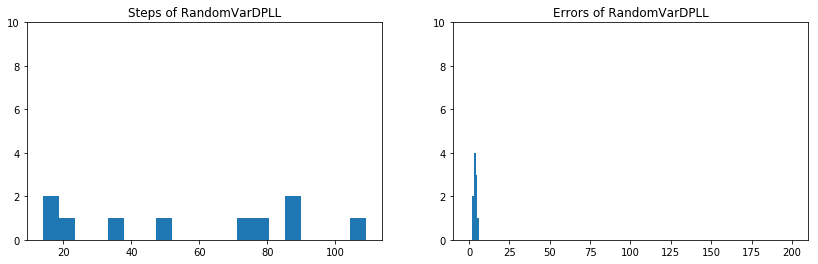

100%|██████████| 10/10 [00:00<00:00, 530.54it/s]


#Sats: 10; avg step: 54.00; stdev step: 39.71; avg error: 2.10; stdev error: 1.22


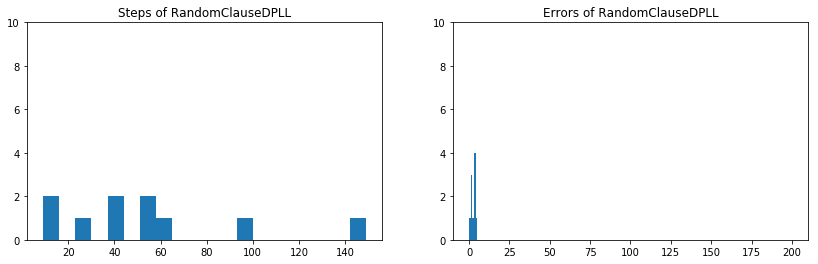

100%|██████████| 10/10 [00:01<00:00,  5.72it/s]


#Sats: 10; avg step: 15.50; stdev step: 11.59; avg error: 0.30; stdev error: 0.46


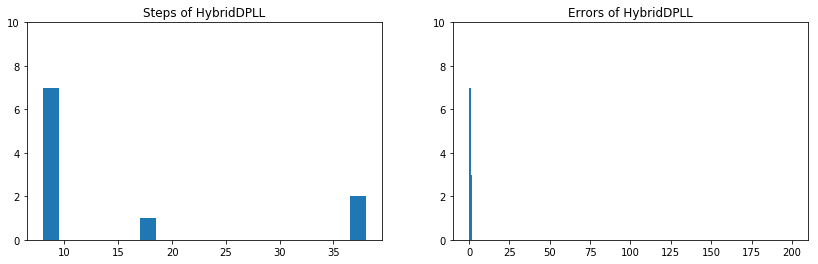

100%|██████████| 10/10 [00:02<00:00,  5.28it/s]


#Sats: 10; avg step: 15.50; stdev step: 11.59; avg error: 0.30; stdev error: 0.46


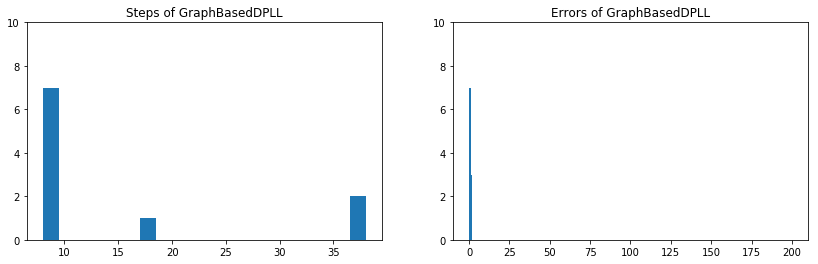

100%|██████████| 10/10 [00:00<00:00, 375.99it/s]


#Sats: 10; avg step: 22.80; stdev step: 22.06; avg error: 1.00; stdev error: 0.77


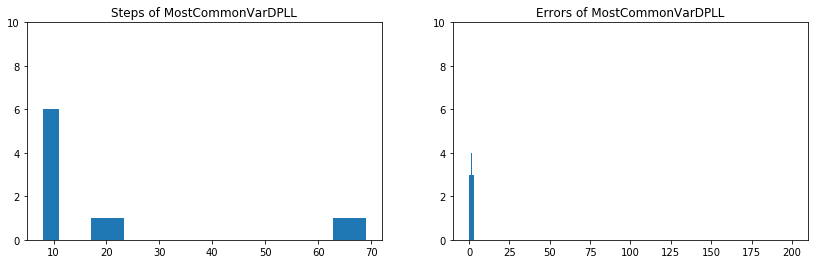

In [18]:
print_all(10, 200, 8)

100%|██████████| 10/10 [00:00<00:00, 173.24it/s]

We have generated 10 formulas
#Sats: 10; avg step: 141.50; stdev step: 83.94; avg error: 5.70; stdev error: 1.68


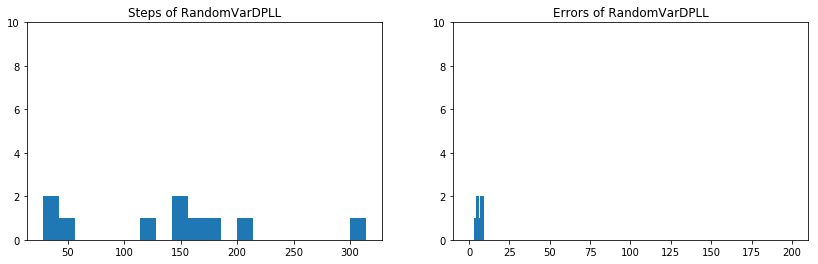

100%|██████████| 10/10 [00:00<00:00, 161.45it/s]


#Sats: 10; avg step: 93.40; stdev step: 56.79; avg error: 3.30; stdev error: 1.42


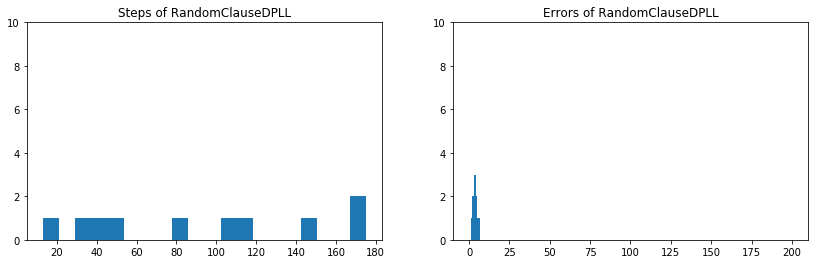

100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


#Sats: 10; avg step: 21.30; stdev step: 31.57; avg error: 0.10; stdev error: 0.30


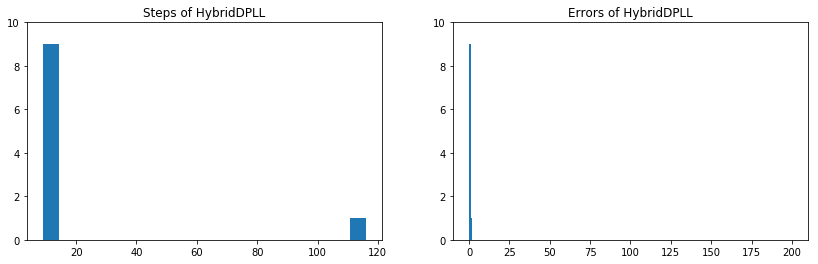

100%|██████████| 10/10 [00:03<00:00,  3.26it/s]


#Sats: 10; avg step: 21.30; stdev step: 31.57; avg error: 0.10; stdev error: 0.30


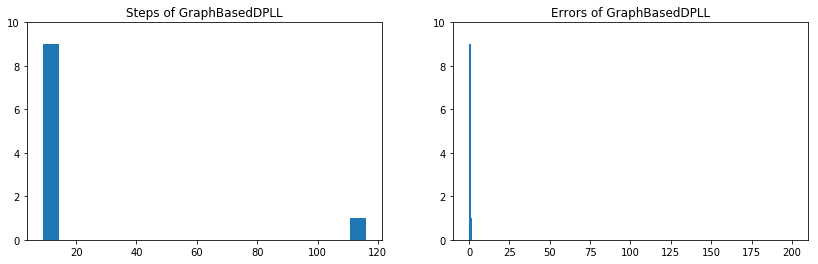

100%|██████████| 10/10 [00:00<00:00, 484.72it/s]


#Sats: 10; avg step: 40.00; stdev step: 34.51; avg error: 1.10; stdev error: 0.83


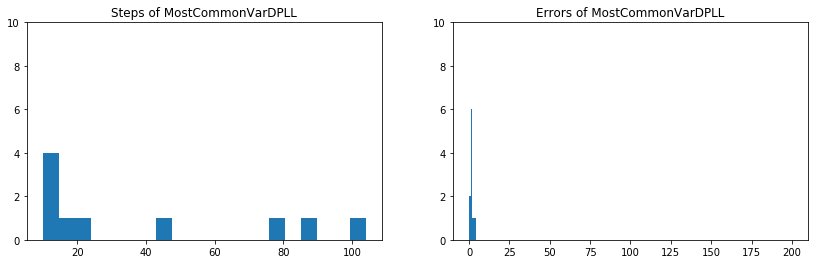

In [19]:
print_all(10, 200, 10)

100%|██████████| 10/10 [00:00<00:00, 108.46it/s]

We have generated 10 formulas
#Sats: 10; avg step: 265.60; stdev step: 192.30; avg error: 5.80; stdev error: 1.94


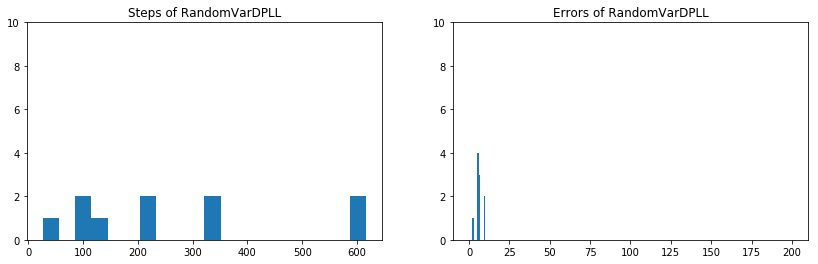

100%|██████████| 10/10 [00:00<00:00, 132.03it/s]


#Sats: 10; avg step: 191.80; stdev step: 177.60; avg error: 3.80; stdev error: 2.23


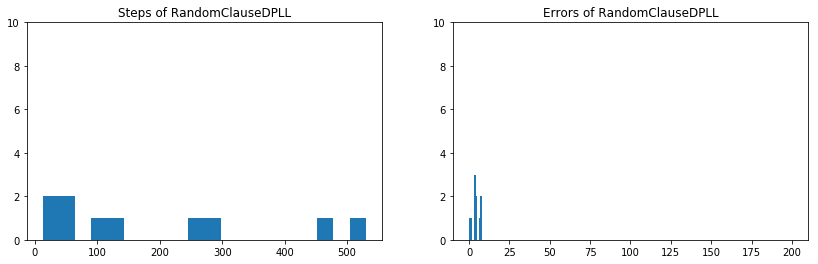

100%|██████████| 10/10 [00:04<00:00,  3.20it/s]


#Sats: 10; avg step: 61.10; stdev step: 123.93; avg error: 0.40; stdev error: 0.92


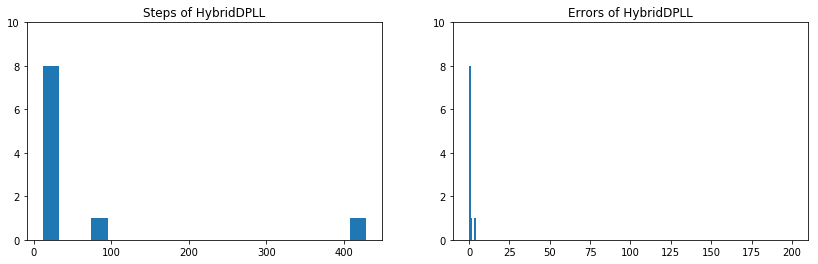

100%|██████████| 10/10 [00:06<00:00,  2.74it/s]


#Sats: 10; avg step: 59.70; stdev step: 119.78; avg error: 0.20; stdev error: 0.40


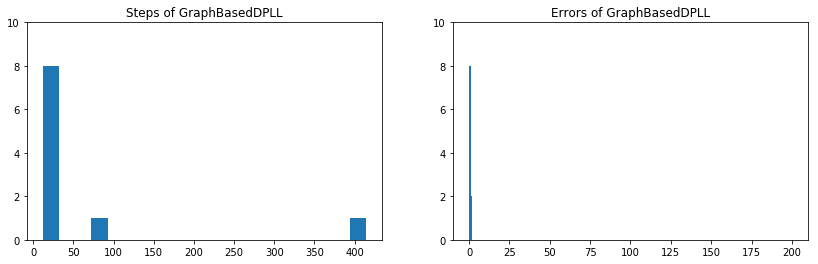

100%|██████████| 10/10 [00:00<00:00, 189.33it/s]


#Sats: 10; avg step: 77.20; stdev step: 77.69; avg error: 1.60; stdev error: 0.80


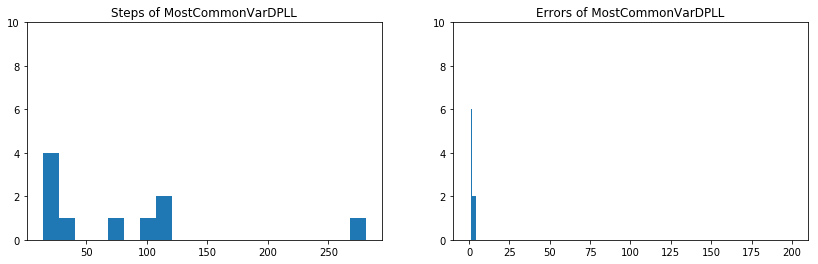

In [20]:
print_all(10, 200, 12)

 60%|██████    | 6/10 [00:00<00:00, 29.17it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:00<00:00, 30.24it/s]


#Sats: 10; avg step: 732.90; stdev step: 238.36; avg error: 8.00; stdev error: 1.61


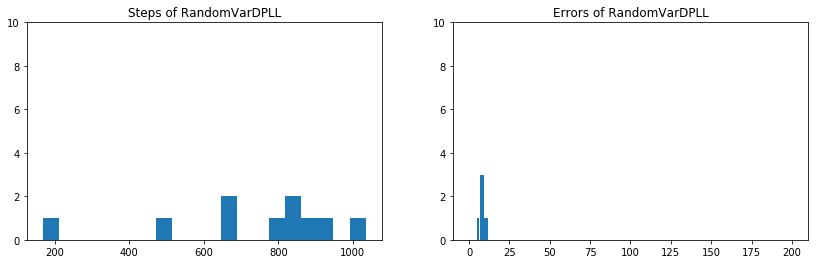

100%|██████████| 10/10 [00:00<00:00, 56.40it/s]


#Sats: 10; avg step: 362.30; stdev step: 193.27; avg error: 4.80; stdev error: 1.54


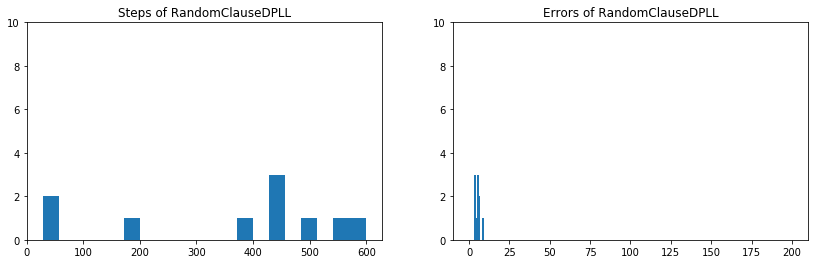

100%|██████████| 10/10 [00:04<00:00,  2.68it/s]


#Sats: 10; avg step: 19.40; stdev step: 13.87; avg error: 0.10; stdev error: 0.30


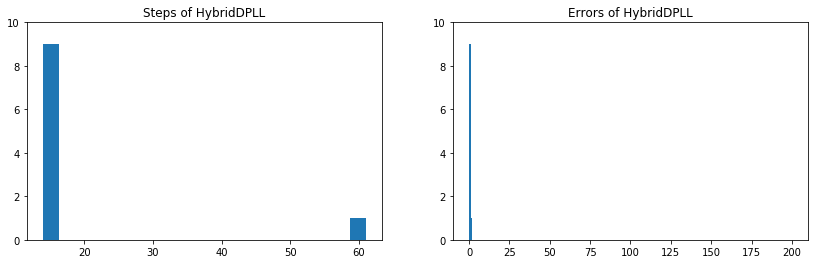

100%|██████████| 10/10 [00:04<00:00,  2.73it/s]


#Sats: 10; avg step: 19.40; stdev step: 13.87; avg error: 0.10; stdev error: 0.30


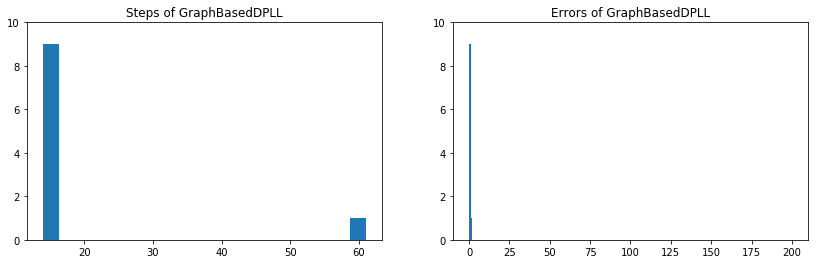

100%|██████████| 10/10 [00:00<00:00, 147.79it/s]


#Sats: 10; avg step: 92.70; stdev step: 92.47; avg error: 1.60; stdev error: 0.92


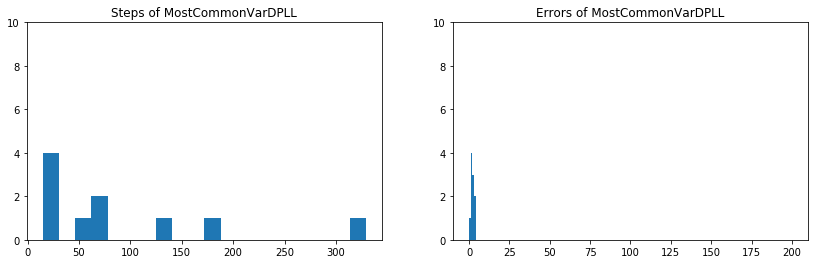

In [21]:
print_all(10, 200, 14)

 20%|██        | 2/10 [00:00<00:00, 19.42it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:00<00:00, 20.81it/s]


#Sats: 10; avg step: 1064.60; stdev step: 733.86; avg error: 8.70; stdev error: 2.10


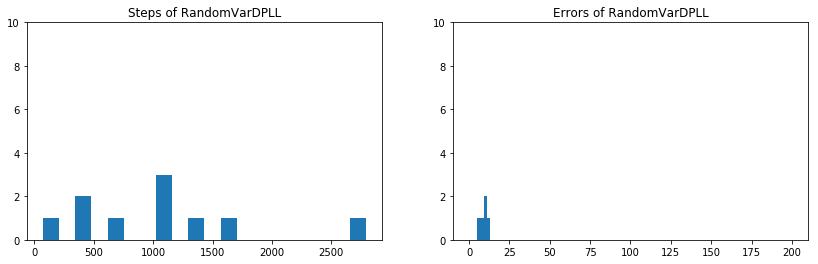

100%|██████████| 10/10 [00:00<00:00, 26.68it/s]


#Sats: 10; avg step: 771.90; stdev step: 403.12; avg error: 5.00; stdev error: 1.41


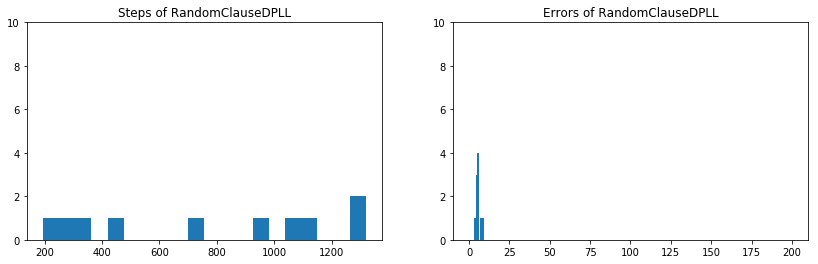

100%|██████████| 10/10 [00:07<00:00,  1.61it/s]


#Sats: 10; avg step: 118.20; stdev step: 215.80; avg error: 0.30; stdev error: 0.64


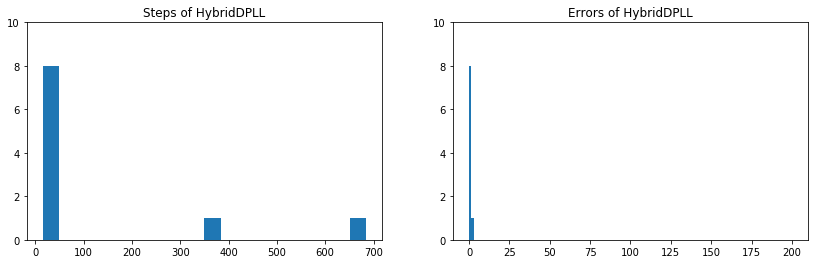

100%|██████████| 10/10 [00:24<00:00,  2.21s/it]


#Sats: 10; avg step: 222.00; stdev step: 473.11; avg error: 0.30; stdev error: 0.64


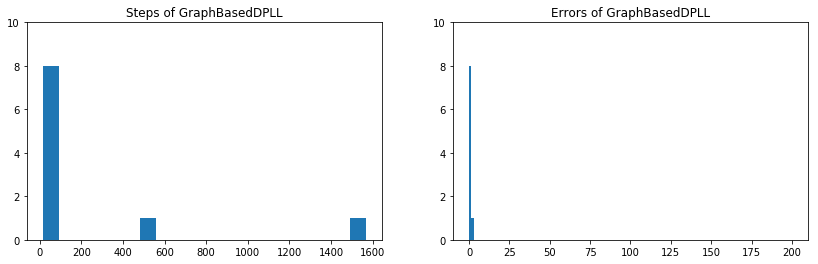

100%|██████████| 10/10 [00:00<00:00, 72.59it/s]


#Sats: 10; avg step: 232.80; stdev step: 265.48; avg error: 2.10; stdev error: 0.83


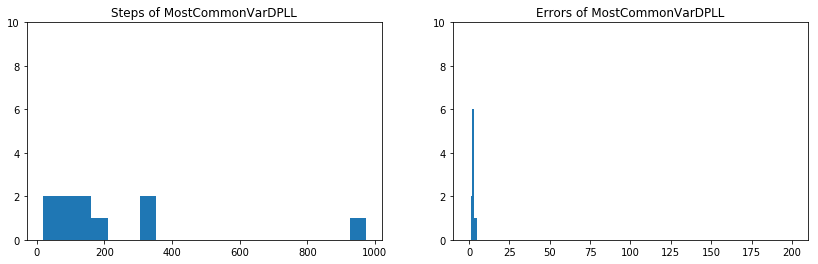

In [22]:
print_all(10, 200, 16)

 10%|█         | 1/10 [00:00<00:01,  7.44it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:00<00:00,  9.53it/s]


#Sats: 10; avg step: 2138.20; stdev step: 996.24; avg error: 8.30; stdev error: 2.90


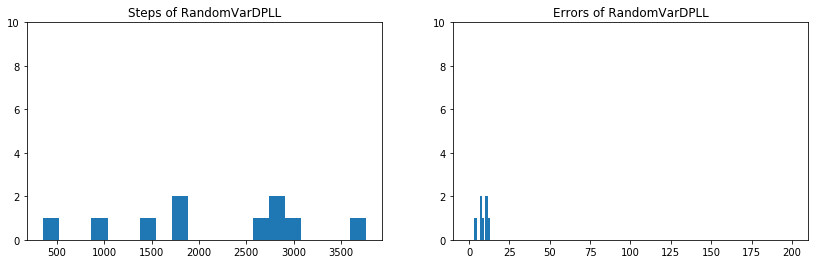

100%|██████████| 10/10 [00:00<00:00, 10.97it/s]


#Sats: 10; avg step: 1784.90; stdev step: 685.90; avg error: 6.00; stdev error: 2.24


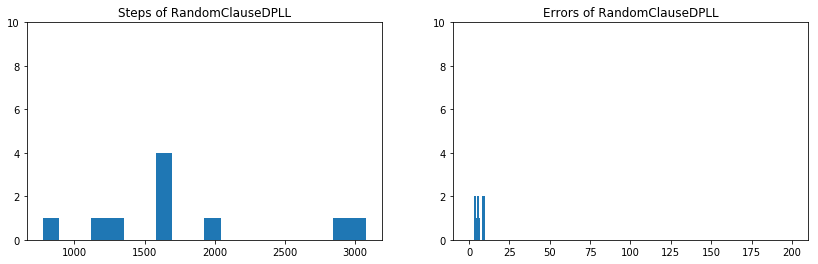

100%|██████████| 10/10 [00:11<00:00,  1.27it/s]


#Sats: 10; avg step: 305.80; stdev step: 453.68; avg error: 1.40; stdev error: 1.74


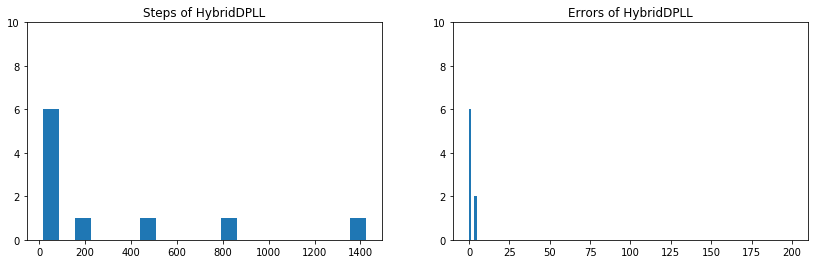

100%|██████████| 10/10 [00:59<00:00,  2.54s/it]


#Sats: 10; avg step: 568.00; stdev step: 903.05; avg error: 0.60; stdev error: 0.80


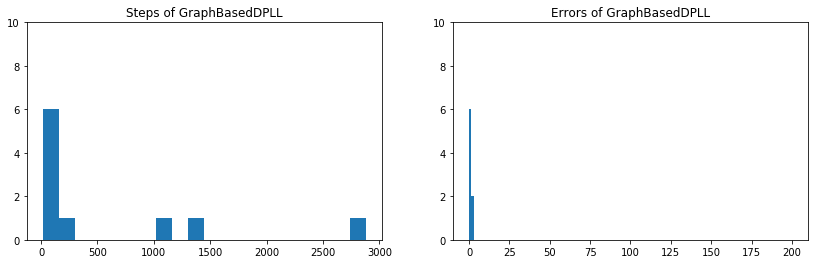

100%|██████████| 10/10 [00:00<00:00, 35.04it/s]


#Sats: 10; avg step: 397.00; stdev step: 432.41; avg error: 2.50; stdev error: 1.02


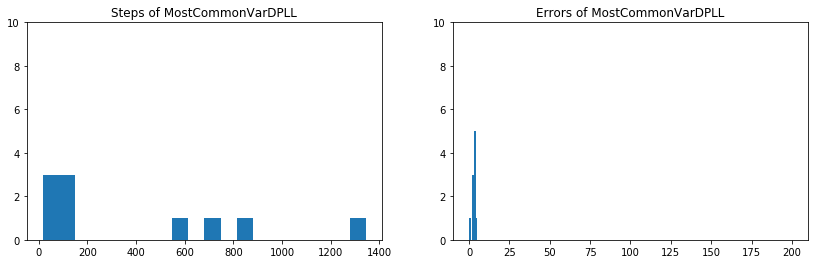

In [23]:
print_all(10, 200, 18)

  0%|          | 0/10 [00:00<?, ?it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:02<00:00,  3.90it/s]


#Sats: 10; avg step: 4942.60; stdev step: 2534.90; avg error: 9.70; stdev error: 2.00


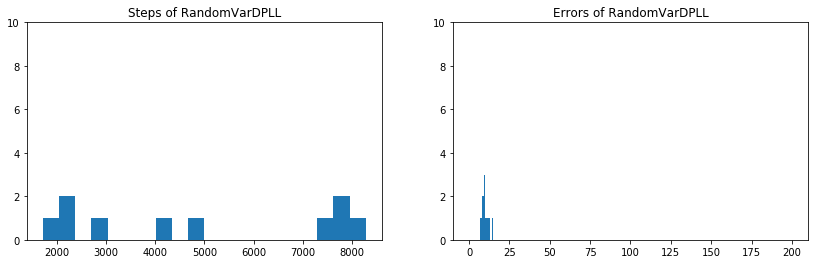

100%|██████████| 10/10 [00:01<00:00,  5.40it/s]


#Sats: 10; avg step: 3023.10; stdev step: 2595.65; avg error: 6.50; stdev error: 1.69


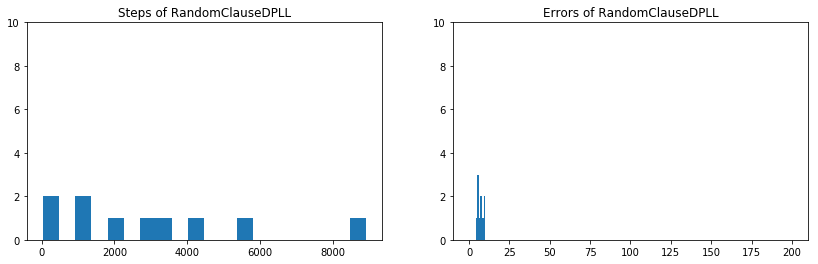

100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


#Sats: 10; avg step: 254.40; stdev step: 424.29; avg error: 0.90; stdev error: 1.37


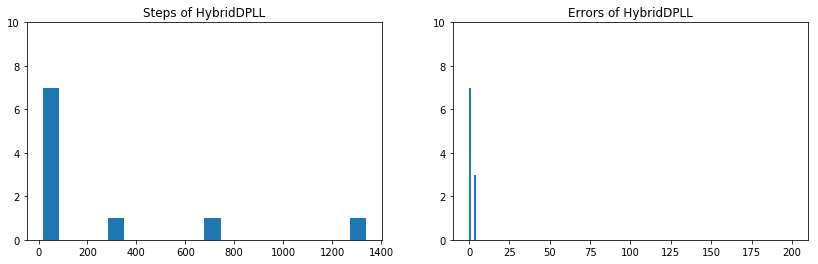

100%|██████████| 10/10 [00:59<00:00,  3.30s/it]


#Sats: 10; avg step: 486.50; stdev step: 827.61; avg error: 0.30; stdev error: 0.46


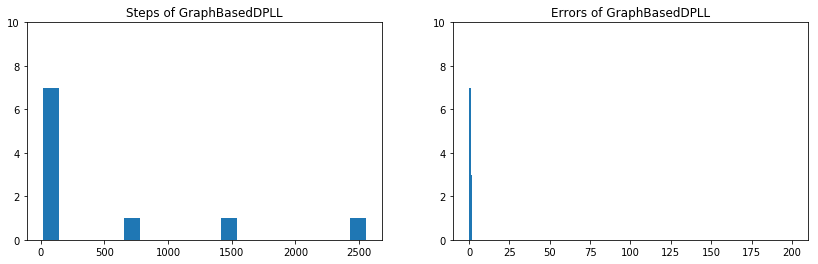

100%|██████████| 10/10 [00:00<00:00, 12.29it/s]


#Sats: 10; avg step: 1079.30; stdev step: 810.79; avg error: 3.70; stdev error: 1.55


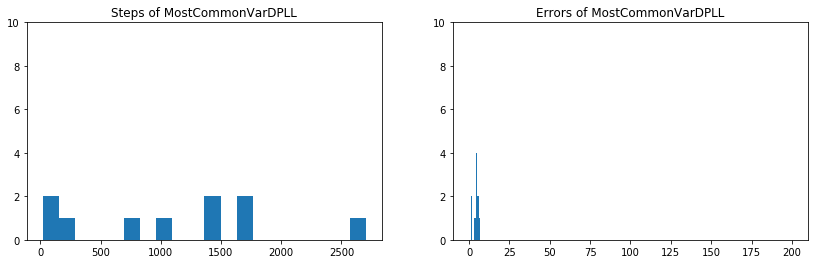

In [24]:
print_all(10, 200, 20)

 10%|█         | 1/10 [00:00<00:02,  3.10it/s]

We have generated 10 formulas


100%|██████████| 10/10 [00:10<00:00,  1.18s/it]


#Sats: 10; avg step: 14778.30; stdev step: 11881.69; avg error: 12.90; stdev error: 3.33


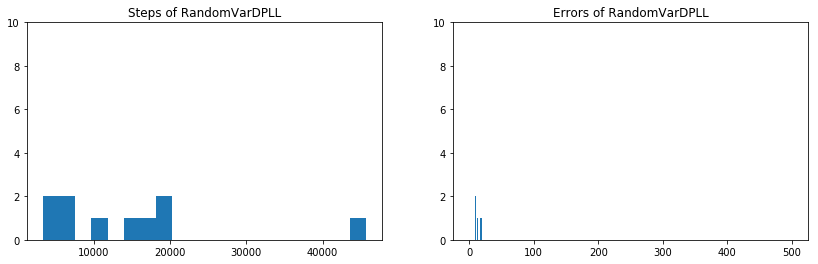

100%|██████████| 10/10 [00:11<00:00,  1.15s/it]


#Sats: 10; avg step: 15225.60; stdev step: 6767.78; avg error: 8.60; stdev error: 2.50


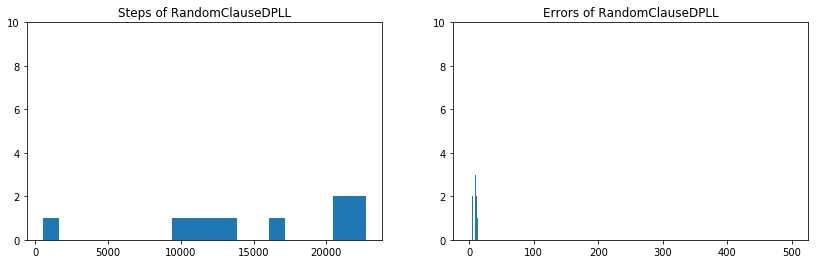

100%|██████████| 10/10 [00:16<00:00,  1.11s/it]


#Sats: 10; avg step: 722.40; stdev step: 1093.60; avg error: 1.20; stdev error: 1.89


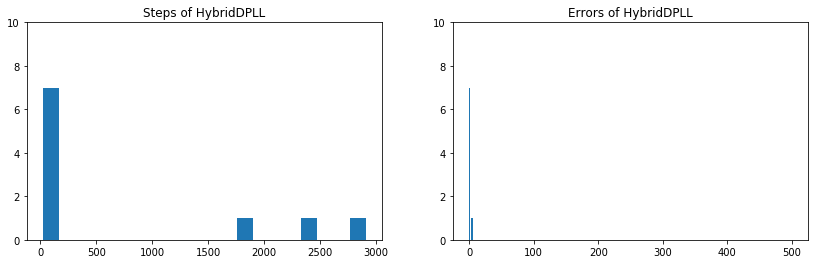

 30%|███       | 3/10 [03:31<05:59, 51.32s/it]

In [ ]:
print_all(10, 500, 25)

In [ ]:
print_all(10, 400, 8)

In [ ]:
print_all(10, 800, 8)

In [ ]:
print_all(10, 1200, 8)

In [ ]:
print_all(10, 1600, 8)

In [ ]:
print_all(10, 2000, 8)

In [ ]:
print_all(10, 3000, 8)

In [ ]:
print_all(10, 500, 30)

In [ ]:
print_all(10, 500, 40)

In [ ]:
print_all(10, 500, 50)